Импорт библиотек и загрузка данных

In [1]:
# 1. Импортируем стандартные библиотеки
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('../')
print(f"Рабочая директория: {os.getcwd()}")


# 2. Импортируем функции из нашего файла coco_utils.py
from coco_utils import load_coco_data

# 3. Настраиваем matplotlib для красивого отображения картинок
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 4. Вызываем функцию загрузки данных
print("\nЗагружаем данные COCO...")
data = load_coco_data(base_dir='data', pca_features=True, max_train=5000)
print("Данные загружены.")

# 5. Выводим информацию о загруженных данных для проверки
print("\nКлючи в загруженном словаре данных:")
for k, v in data.items():
    if isinstance(v, np.ndarray):
        print(f"- {k}: массив numpy с формой {v.shape}")
    else:
        print(f"- {k}: объект типа {type(v)}")

# 6. Смотрим на словари для перевода слов в индексы и обратно
print(f"\nРазмер словаря (количество уникальных слов): {len(data['word_to_idx'])}")
print(f"Индекс для токена <START> -> {data['word_to_idx']['<START>']}")
print(f"Слово для индекса 1 -> {data['idx_to_word'][1]}")

Рабочая директория: /Users/kris/Documents/sem7/MLOps/cnn_rnn/cnn_rnn_lab

Загружаем данные COCO...
base dir  data
Данные загружены.

Ключи в загруженном словаре данных:
- train_captions: массив numpy с формой (5000, 17)
- train_image_idxs: массив numpy с формой (5000,)
- val_captions: массив numpy с формой (195954, 17)
- val_image_idxs: массив numpy с формой (195954,)
- train_features: массив numpy с формой (82783, 512)
- val_features: массив numpy с формой (40504, 512)
- idx_to_word: объект типа <class 'list'>
- word_to_idx: объект типа <class 'dict'>
- train_urls: массив numpy с формой (82783,)
- val_urls: массив numpy с формой (40504,)

Размер словаря (количество уникальных слов): 1004
Индекс для токена <START> -> 1
Слово для индекса 1 -> <START>


Визуализация данных

Примеры изображений и их подписей из обучающей выборки:


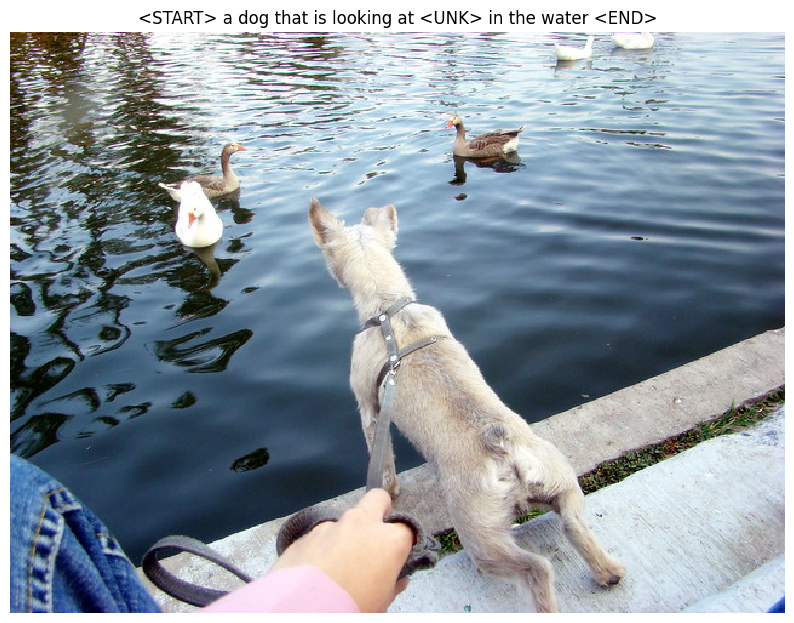

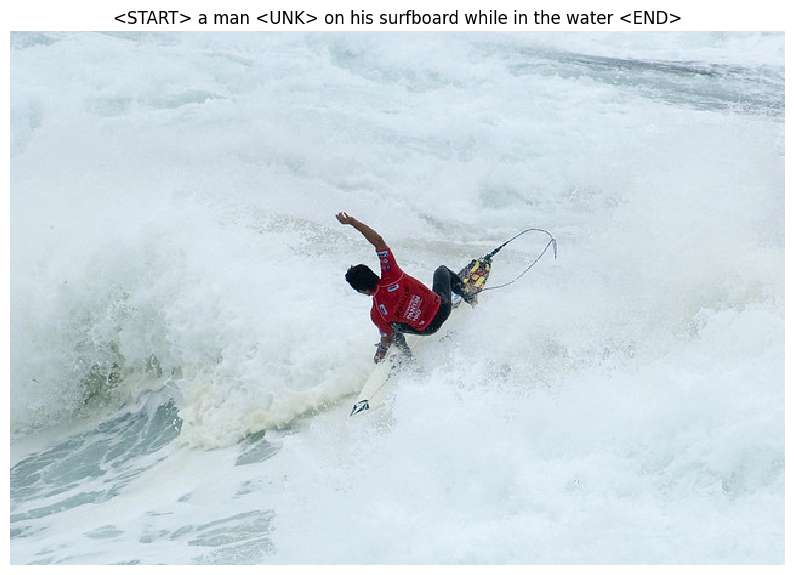

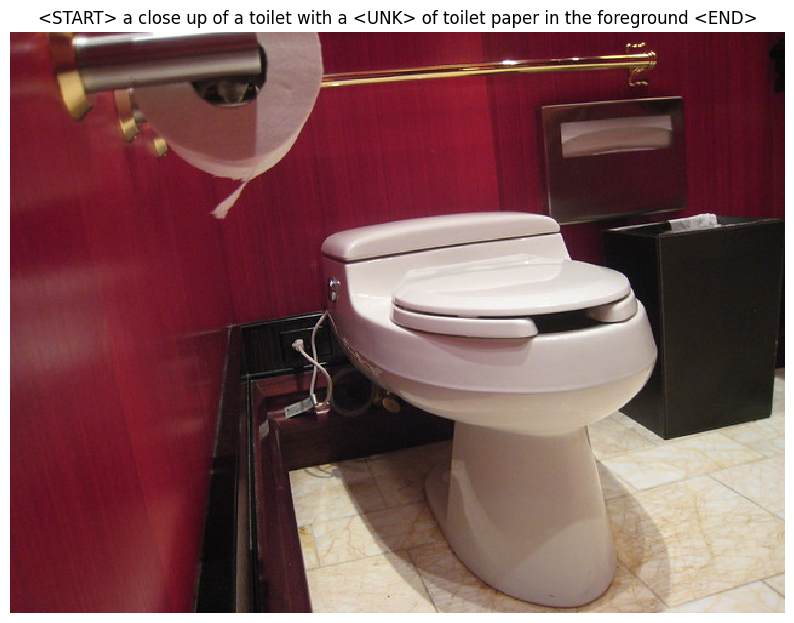

In [3]:
# 1. Импортируем еще две полезные функции из нашего файла
from coco_utils import sample_coco_minibatch, decode_captions
from PIL import Image
from io import BytesIO
import requests

# 2. Создадим свою функцию для загрузки изображения по URL
def image_from_url(url):
    """Загружает и возвращает изображение по URL."""
    try:
        response = requests.get(url)
        return Image.open(BytesIO(response.content))
    except:
        print(f"Не удалось загрузить изображение по URL: {url}")
        # Возвращаем пустое серое изображение в случае ошибки
        return Image.new('RGB', (200, 200), color = 'gray')

# 3. Получаем случайный мини-батч (небольшую порцию) данных
#    Функция sample_coco_minibatch сама найдет соответствующие картинки для подписей
batch_size = 3
captions_batch, features_batch, urls_batch = sample_coco_minibatch(
    data, 
    batch_size=batch_size, 
    split='train' # Берем данные из обучающей выборки
)

# 4. Проходим по нашему мини-батчу и выводим картинки с подписями
print("Примеры изображений и их подписей из обучающей выборки:")
for i in range(batch_size):
    # Получаем URL картинки
    url = urls_batch[i]
    
    # Получаем числовое представление подписи
    caption_nums = captions_batch[i]
    
    # Декодируем подпись обратно в текст
    caption_text = decode_captions(caption_nums, data['idx_to_word'])
    
    # Загружаем и отображаем изображение
    img = image_from_url(url)
    plt.imshow(img)
    plt.axis('off') # Убираем оси координат
    plt.title(caption_text)
    plt.show()

Определение архитектуры RNN-декодера (a) Init-inject

In [4]:
import torch
import torch.nn as nn

# Определяем основные параметры для нашей будущей модели
WORD_VEC_SIZE = 256  # Размер вектора для каждого слова
HIDDEN_SIZE = 512    # Размер скрытого состояния в RNN
IMG_FEAT_SIZE = 512  # Размер вектора признаков изображения (из PCA-версии)
VOCAB_SIZE = len(data['word_to_idx']) # Размер нашего словаря (1004)

class CaptioningRNN(nn.Module):
    def __init__(self, word_vec_size, hidden_size, vocab_size, img_feat_size):
        super().__init__()
        
        # --- Слои модели ---
        
        # 1. Слой для признаков изображения (Image features layer)
        #    Преобразует вектор признаков картинки в нужный размер для скрытого состояния RNN.
        #    Вход: IMG_FEAT_SIZE (512), Выход: HIDDEN_SIZE (512)
        self.img_to_hidden = nn.Linear(img_feat_size, hidden_size)

        # 2. Слой для встраивания слов (Word embedding layer)
        #    Преобразует индекс слова (например, 56) в плотный вектор (размером WORD_VEC_SIZE).
        #    Это как бы "смысловой" вектор для каждого слова.
        self.word_embedding = nn.Embedding(vocab_size, word_vec_size)

        # 3. Рекуррентный слой (LSTM)
        #    Основной "движок" модели, который обрабатывает последовательность слов.
        #    Вход: вектор слова, Выход: новое скрытое состояние
        self.lstm = nn.LSTM(word_vec_size, hidden_size)

        # 4. Выходной слой (Output layer)
        #    Преобразует скрытое состояние RNN в "оценки" (логиты) для каждого слова в словаре.
        #    Вход: HIDDEN_SIZE (512), Выход: VOCAB_SIZE (1004)
        self.hidden_to_vocab = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        """
        Прямой проход для обучения модели.
        features: признаки изображений, форма (N, D_img)
        captions: подписи, форма (N, T)
        """
        # Убираем токен <END> из подписей, он нам не нужен для входа
        captions_in = captions[:, :-1]
        
        # 1. Получаем встраивания (embeddings) для входных слов
        #    (N, T-1) -> (N, T-1, D_word)
        word_embeds = self.word_embedding(captions_in)
        
        # Транспонируем, так как RNN в PyTorch ожидает (T, N, D_word)
        word_embeds = word_embeds.transpose(0, 1)

        # 2. Используем признаки изображения для инициализации скрытого состояния LSTM
        #    (N, D_img) -> (N, D_hidden)
        initial_hidden = self.img_to_hidden(features)
        
        # LSTM требует скрытое состояние в виде кортежа (h0, c0)
        # Мы будем использовать один и тот же вектор для обоих
        # Форма должна быть (1, N, D_hidden)
        h0 = initial_hidden.unsqueeze(0)
        c0 = initial_hidden.unsqueeze(0)

        # 3. Прогоняем последовательность через LSTM
        #    lstm_out будет иметь форму (T-1, N, D_hidden)
        lstm_out, _ = self.lstm(word_embeds, (h0, c0))
        
        # 4. Получаем оценки для каждого слова в словаре
        #    (T-1, N, D_hidden) -> (T-1, N, V)
        vocab_scores = self.hidden_to_vocab(lstm_out)

        # Транспонируем обратно в (N, T-1, V) для удобства подсчета потерь
        vocab_scores = vocab_scores.transpose(0, 1)
        
        return vocab_scores

# --- Создаем экземпляр нашей модели ---
rnn_model = CaptioningRNN(
    word_vec_size=WORD_VEC_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=VOCAB_SIZE,
    img_feat_size=IMG_FEAT_SIZE
)

print("Класс модели CaptioningRNN успешно определен.")
print("Экземпляр модели создан.")

Класс модели CaptioningRNN успешно определен.
Экземпляр модели создан.


Определение функции потерь и оптимизатора 

In [ ]:
# 1. Определяем устройство, на котором будем проводить вычисления (GPU или CPU)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Будем использовать Apple MPS (GPU).")
else:
    device = torch.device('cpu')
    print("GPU (MPS) не найдена. Будем использовать CPU.")

# Перемещаем нашу модель на выбранное устройство
rnn_model.to(device)

# 2. Определяем функцию потерь (этот блок правильный, без изменений)
loss_fn = nn.CrossEntropyLoss(ignore_index=data['word_to_idx']['<NULL>'])

# 3. Определяем оптимизатор (этот блок правильный, без изменений)
learning_rate = 1e-3 # 0.001 - стандартное значение
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

# 4. Определяем планировщик скорости обучения
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer
    mode='min',      # Мы следим за минимизацией потерь
    factor=0.1,      # Уменьшаем lr в 10 раз (0.001 -> 0.0001)
    patience=5       # Ждем 5 эпох без улучшений, прежде чем уменьшить
)

print("\nФункция потерь, оптимизатор и планировщик успешно определены.")
print(f"Модель и вычисления будут выполняться на устройстве: {device}")

Будем использовать Apple MPS (GPU).

Функция потерь, оптимизатор и планировщик успешно определены.
Модель и вычисления будут выполняться на устройстве: mps


тк на 15 эпохах после 3ей началось переобучение, то будем использовать 3 эпохи

Эпоха 1/15 | Train Loss: 2.7419 | Val Loss: 3.1092

Эпоха 2/15 | Train Loss: 2.4949 | Val Loss: 3.0669

Эпоха 3/15 | Train Loss: 2.2792 | Val Loss: 3.0465

Эпоха 4/15 | Train Loss: 2.0669 | Val Loss: 3.0555

Эпоха 5/15 | Train Loss: 1.8755 | Val Loss: 3.0811

Эпоха 6/15 | Train Loss: 1.6700 | Val Loss: 3.1217

Эпоха 7/15 | Train Loss: 1.4786 | Val Loss: 3.1832

...

Цикл обучения Init-inject

In [6]:
from torch.utils.data import TensorDataset, DataLoader

# 1. Подготовка данных для загрузчика (DataLoader)

# Создаем TensorDataset для обучающей выборки.
# Он "связывает" подписи с индексами соответствующих картинок.
train_dataset = TensorDataset(
    torch.from_numpy(data['train_captions']).long(),
    torch.from_numpy(data['train_image_idxs'])
)
# Создаем DataLoader. shuffle=True перемешивает данные перед каждой эпохой.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


# Аналогично для валидационной выборки
val_dataset = TensorDataset(
    torch.from_numpy(data['val_captions']).long(),
    torch.from_numpy(data['val_image_idxs'])
)
val_loader = DataLoader(val_dataset, batch_size=128)

# 2. Основной цикл обучения
num_epochs = 3

print("Начинаем обучение...")
for epoch in range(num_epochs):
    
    # --- Фаза обучения (Training) ---
    rnn_model.train()
    total_train_loss = 0.0
    
    for captions, img_idxs in train_loader:
        captions = captions.to(device).long()
        img_idxs = img_idxs.to(device)
        
        features = torch.from_numpy(data['train_features'][img_idxs.cpu()]).to(device)
        
        optimizer.zero_grad()
        
        # 2. Получаем предсказания модели (прямой проход)
        #    Выход `scores` будет иметь форму (N, T-1, V)
        scores = rnn_model(features, captions)
        
        # 3. Считаем ошибку
        #    Нам нужно сравнить предсказания `scores` с целевыми подписями `captions`.
        #    Целевые подписи - это входные, но сдвинутые на один шаг вперед (без <START>).
        captions_target = captions[:, 1:]
        
        # `CrossEntropyLoss` ожидает на вход `scores` в форме (N * (T-1), V) и
        # `captions_target` в форме (N * (T-1)). "Вытягиваем" наши тензоры.
        loss = loss_fn(scores.reshape(-1, VOCAB_SIZE), captions_target.reshape(-1))
        
        # 4. Вычисляем градиенты (обратный проход)
        loss.backward()

        # 5. Обновляем веса модели
        optimizer.step()
        
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    
    # --- Фаза валидации (Validation) ---
    rnn_model.eval() # Переключаем модель в режим оценки
    total_val_loss = 0.0
    
    with torch.no_grad(): # Отключаем расчет градиентов
        for captions, img_idxs in val_loader:
            captions = captions.to(device).long()
            img_idxs = img_idxs.to(device)
            features = torch.from_numpy(data['val_features'][img_idxs.cpu()]).to(device)
            
            scores = rnn_model(features, captions)
            captions_target = captions[:, 1:]
            
            loss = loss_fn(scores.reshape(-1, VOCAB_SIZE), captions_target.reshape(-1))
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)
    
    # --- Вывод результатов эпохи и шаг планировщика ---
    print(f"Эпоха {epoch + 1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")
    
    # Делаем шаг планировщика. Он посмотрит на `avg_val_loss` и решит,
    # нужно ли уменьшать скорость обучения.
    scheduler.step(avg_val_loss)

print("\nОбучение завершено.")

Начинаем обучение...
Эпоха 1/3 | Train Loss: 4.8600 | Val Loss: 4.0255
Эпоха 2/3 | Train Loss: 3.7339 | Val Loss: 3.5757
Эпоха 3/3 | Train Loss: 3.2818 | Val Loss: 3.3189

Обучение завершено.


Функция для генерации подписей


Генерирует подпись для изображения в режиме предсказания (inference).

Inputs:
- model: Обученная модель CaptioningRNN.
- features: Вектор признаков для одного изображения, форма (D_img,).
- max_len: Максимальная длина генерируемой подписи.

Returns:
- caption: Массив numpy с индексами слов сгенерированной подписи.

    

In [7]:
def sample(model, features, max_len=16):
    model.eval() # Переключаем модель в режим оценки
    caption = []
    
    # Готовим входы для LSTM. Он ожидает (1, 1, D_input)
    # Начинаем с токена <START>
    start_token_idx = data['word_to_idx']['<START>']
    word_idx = torch.tensor(start_token_idx).view(1, 1).to(device).long()
    
    # 1. Используем признаки изображения для инициализации скрытого состояния
    with torch.no_grad(): 
        initial_hidden = model.img_to_hidden(features.to(device).unsqueeze(0))
        h = initial_hidden.unsqueeze(0)
        c = initial_hidden.unsqueeze(0)
        
        caption.append(start_token_idx)

        # 2. Пошаговая генерация
        for _ in range(max_len):
            # Получаем встраивание (embedding) для текущего слова
            word_embed = model.word_embedding(word_idx)
            
            # Прогоняем один шаг через LSTM
            lstm_out, (h, c) = model.lstm(word_embed, (h, c))
            
            # Получаем оценки для следующего слова
            scores = model.hidden_to_vocab(lstm_out.squeeze(0))
            
            # Выбираем слово с максимальной оценкой (самое вероятное)
            _, next_word_idx = scores.max(1)
            
            # Добавляем предсказанное слово в нашу подпись
            caption.append(next_word_idx.item())
            
            # Если модель предсказала <END>, останавливаем генерацию
            if next_word_idx.item() == data['word_to_idx']['<END>']:
                break
                
            # Следующим входом для LSTM будет только что предсказанное слово
            word_idx = next_word_idx.unsqueeze(0)
            
    return np.array(caption)

print("Функция sample для генерации подписей определена.")

Функция sample для генерации подписей определена.


Тестирование генерации подписей Init-inject

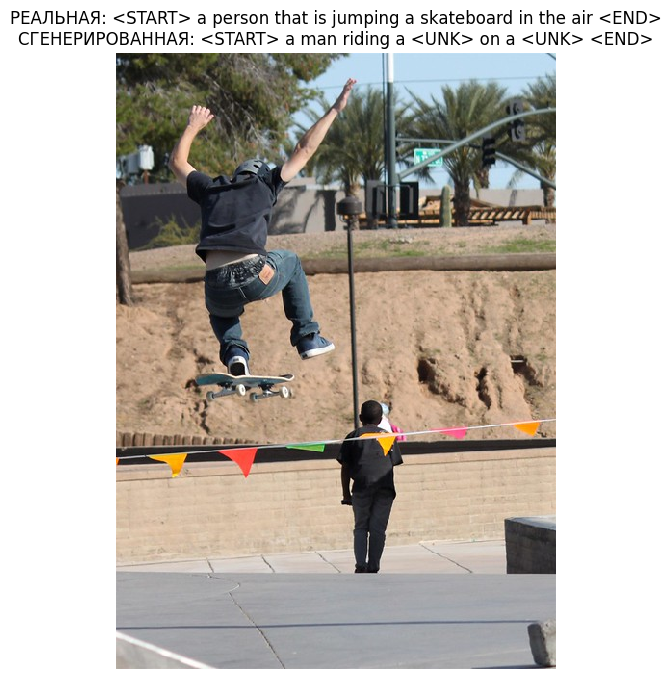

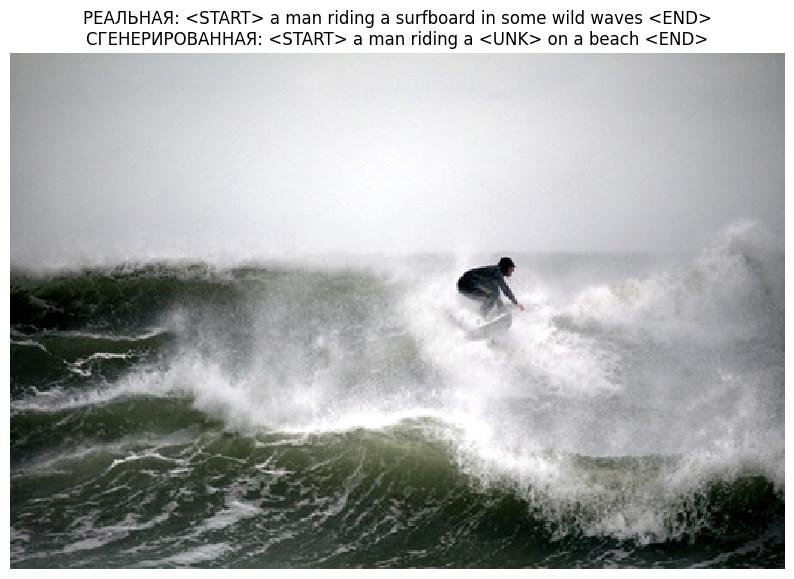

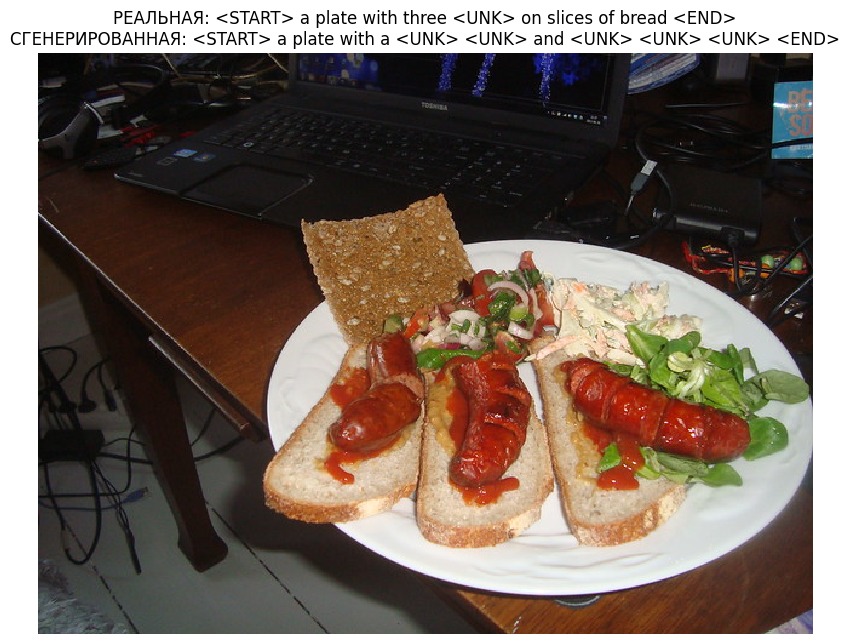

In [11]:
num_samples = 3

for i in range(num_samples):
    # 1. Берем случайный пример из валидационных данных
    #    Используем np.random.choice, чтобы каждый раз были разные картинки
    idx = np.random.choice(len(data['val_captions']))
    
    # Получаем числовое представление реальной подписи и URL картинки
    caption_nums = data['val_captions'][idx]
    url = data['val_urls'][data['val_image_idxs'][idx]]
    
    # 2. Получаем признаки изображения
    features_single = torch.from_numpy(data['val_features'][data['val_image_idxs'][idx]])

    # 3. Генерируем подпись с помощью нашей модели
    generated_caption_nums = sample(rnn_model, features_single)
    
    # 4. Декодируем обе подписи (реальную и сгенерированную) в текст
    real_caption_text = decode_captions(caption_nums, data['idx_to_word'])
    generated_caption_text = decode_captions(generated_caption_nums, data['idx_to_word'])
    
    # 5. Отображаем результат
    img = image_from_url(url)
    plt.imshow(img)
    plt.axis('off')
    
    # Выводим обе подписи под картинкой для сравнения
    plt.title(f"РЕАЛЬНАЯ: {real_caption_text}\nСГЕНЕРИРОВАННАЯ: {generated_caption_text}")
    plt.show()

Ячейка для Финального обучения Init-inject

In [12]:
# --- Шаг 0: Импорт необходимых библиотек ---
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os

# --- Шаг 1: Правильное определение устройства и загрузка данных ---

# --- Проверка MPS для GPU на Mac ---
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Используем Apple MPS (GPU).")
else:
    device = torch.device('cpu')
    print("Используем CPU.")

# Загружаем весь набор данных COCO
print("\nЗагружаем весь набор данных COCO...")
full_data = load_coco_data(base_dir='data', pca_features=True)
print("Данные загружены.")

# Обновляем глобальные переменные размеров
IMG_FEAT_SIZE = full_data['train_features'].shape[1]
VOCAB_SIZE = len(full_data['word_to_idx'])

# --- Шаг 2: Создание новой "чистой" модели для финального обучения ---
final_model = CaptioningRNN(
    word_vec_size=WORD_VEC_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=VOCAB_SIZE,
    img_feat_size=IMG_FEAT_SIZE
).to(device)

loss_fn_final = nn.CrossEntropyLoss(ignore_index=full_data['word_to_idx']['<NULL>'])
optimizer_final = torch.optim.Adam(final_model.parameters(), lr=1e-3)
scheduler_final = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode='min', factor=0.1, patience=3
)

# --- Шаг 3: Подготовка DataLoader'ов на полных данных ---
train_dataset_final = TensorDataset(
    torch.from_numpy(full_data['train_captions']).long(),
    torch.from_numpy(full_data['train_image_idxs'])
)
train_loader_final = DataLoader(train_dataset_final, batch_size=128, shuffle=True) # Уменьшил batch_size для Mac

val_dataset_final = TensorDataset(
    torch.from_numpy(full_data['val_captions']).long(),
    torch.from_numpy(full_data['val_image_idxs'])
)
val_loader_final = DataLoader(val_dataset_final, batch_size=128) # Уменьшил batch_size для Mac


# --- Шаг 4: Цикл обучения (с исправленной логикой) ---
num_epochs_final = 3

print(f"\nНачинаем финальное обучение на {num_epochs_final} эпох на устройстве: {device}...")
for epoch in range(num_epochs_final):
    final_model.train()
    total_train_loss = 0.0
    for captions, img_idxs in train_loader_final:
        captions = captions.to(device)
        img_idxs = img_idxs.to(device)
        
        # Индексация должна происходить на CPU, результат переносится на GPU
        features = torch.from_numpy(full_data['train_features'][img_idxs.cpu()]).to(device)
        
        optimizer_final.zero_grad()
        scores = final_model(features, captions)
        captions_target = captions[:, 1:]
        loss = loss_fn_final(scores.reshape(-1, VOCAB_SIZE), captions_target.reshape(-1))
        loss.backward()
        optimizer_final.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader_final)
    
    final_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for captions, img_idxs in val_loader_final:
            captions = captions.to(device)
            img_idxs = img_idxs.to(device)
            features = torch.from_numpy(full_data['val_features'][img_idxs.cpu()]).to(device)
            scores = final_model(features, captions)
            captions_target = captions[:, 1:]
            loss = loss_fn_final(scores.reshape(-1, VOCAB_SIZE), captions_target.reshape(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader_final)
    
    print(f"Эпоха {epoch + 1}/{num_epochs_final} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")
    
    scheduler_final.step(avg_val_loss)

print("\nОбучение завершено.")


# --- Шаг 5: Сохранение модели в папку ---
os.makedirs('models', exist_ok=True) 

# Составляем правильный путь к файлу
save_path = os.path.join('models', 'init_inject_final_model.pth')
torch.save(final_model.state_dict(), save_path)
print(f"Веса модели сохранены в файл: '{save_path}'")

Используем Apple MPS (GPU).

Загружаем весь набор данных COCO...
base dir  data
Данные загружены.

Начинаем финальное обучение на 3 эпох на устройстве: mps...
Эпоха 1/3 | Train Loss: 2.4792 | Val Loss: 2.2897
Эпоха 2/3 | Train Loss: 2.2163 | Val Loss: 2.3035
Эпоха 3/3 | Train Loss: 2.1434 | Val Loss: 2.2652

Обучение завершено.
Веса модели сохранены в файл: 'models/init_inject_final_model.pth'


Обучение на 4 эпохах после 3 эпохи стало переобучаться, поэтому оставлю 3

Эпоха 1/4 | Train Loss: 2.4793 | Val Loss: 2.2897

Эпоха 2/4 | Train Loss: 2.1767 | Val Loss: 2.2397

Эпоха 3/4 | Train Loss: 2.1008 | Val Loss: 2.2299

Эпоха 4/4 | Train Loss: 2.0532 | Val Loss: 2.2311

Ячейка для тестирования Финальной модели

Генерируем подписи с помощью финальной, обученной модели:


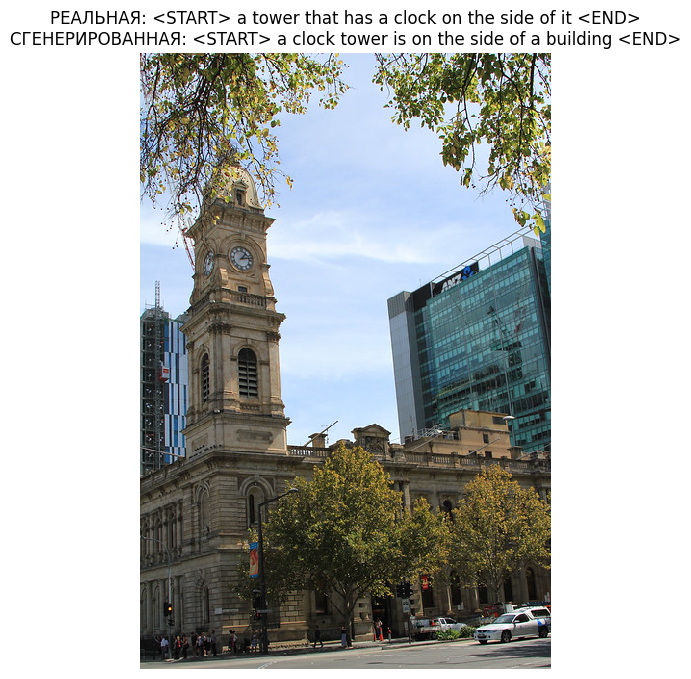

Не удалось загрузить изображение по URL: http://farm1.staticflickr.com/54/125659640_404b3b43a8_z.jpg


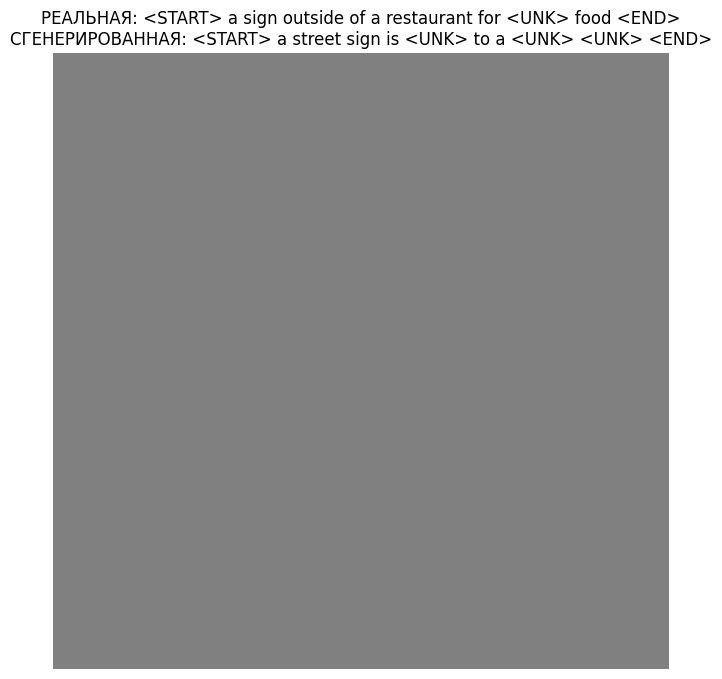

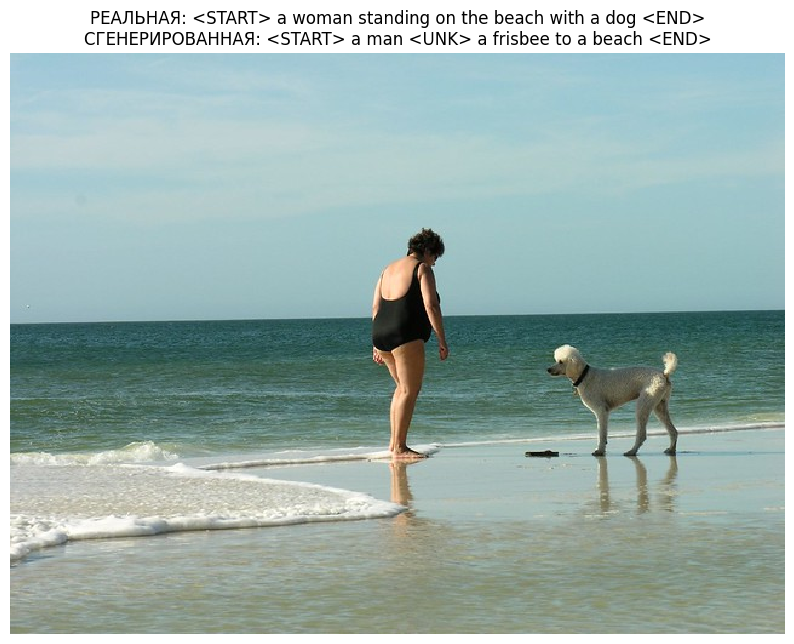

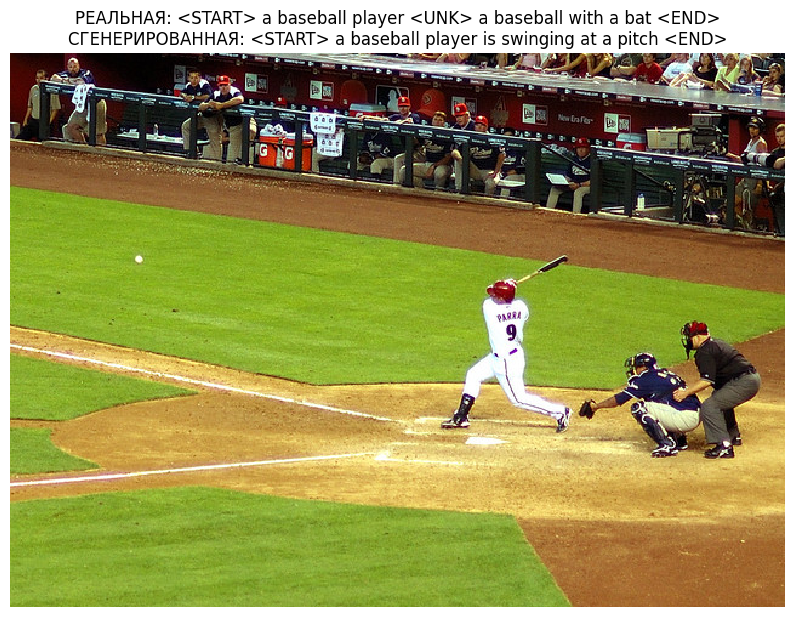

In [16]:
# 1. Загружать модель с диска не нужно, так как она уже есть в памяти

# 2. Возьмем несколько случайных примеров из валидационной выборки
num_samples = 4 

print("Генерируем подписи с помощью финальной, обученной модели:")
for i in range(num_samples):
    # Берем случайный пример
    idx = np.random.choice(len(full_data['val_captions']))
    
    caption_nums = full_data['val_captions'][idx]
    url = full_data['val_urls'][full_data['val_image_idxs'][idx]]
    
    # Получаем признаки изображения
    features_single = torch.from_numpy(full_data['val_features'][full_data['val_image_idxs'][idx]])

    # Генерируем подпись с помощью НАШЕЙ НОВОЙ МОДЕЛИ
    generated_caption_nums = sample(final_model, features_single) # <<<--- Используем final_model
    
    # Декодируем подписи
    real_caption_text = decode_captions(caption_nums, full_data['idx_to_word'])
    generated_caption_text = decode_captions(generated_caption_nums, full_data['idx_to_word'])
    
    # Отображаем результат
    img = image_from_url(url)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"РЕАЛЬНАЯ: {real_caption_text}\nСГЕНЕРИРОВАННАЯ: {generated_caption_text}")
    plt.show()

Ячейка для определения второй архитектуры: (b) Pre-inject

In [ ]:
class CaptioningRNN_PreInject(nn.Module):
    def __init__(self, word_vec_size, hidden_size, vocab_size, img_feat_size):
        super().__init__()
        
        # 1. Преобразует вектор картинки в тот же размер, что и вектор слова
        self.img_to_word_vec = nn.Linear(img_feat_size, word_vec_size)
        
        # Остальные слои те же самые
        self.word_embedding = nn.Embedding(vocab_size, word_vec_size)
        self.lstm = nn.LSTM(word_vec_size, hidden_size)
        self.hidden_to_vocab = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # Убираем токен <END>
        captions_in = captions[:, :-1]
        
        # 1. Получаем встраивания (embeddings) для слов
        #    (N, T-1) -> (N, T-1, D_word)
        word_embeds = self.word_embedding(captions_in)
        
        # 2. Преобразуем признаки изображения в "псевдо-вектор слова"
        #    (N, D_img) -> (N, D_word)
        img_embeds = self.img_to_word_vec(features)
        
        # Добавляем измерение времени: (N, D_word) -> (N, 1, D_word)
        img_embeds = img_embeds.unsqueeze(1)
        
        # 3. Объединяем вектор картинки и векторы слов в одну последовательность
        #    (N, 1, D_word) + (N, T-1, D_word) -> (N, T, D_word)
        full_sequence = torch.cat([img_embeds, word_embeds], dim=1)
        
        # Транспонируем для LSTM: (T, N, D_word)
        full_sequence = full_sequence.transpose(0, 1)

        # 4. Прогоняем ПОЛНУЮ последовательность через LSTM.
        lstm_out, _ = self.lstm(full_sequence)
        
        # 5. Получаем оценки для каждого слова в словаре
        #    (T, N, D_hidden) -> (T, N, V)
        vocab_scores = self.hidden_to_vocab(lstm_out)

        # Транспонируем обратно в (N, T, V)
        vocab_scores = vocab_scores.transpose(0, 1)
        
        # Так как наша последовательность на 1 длиннее (из-за картинки),
        # мы должны обрезать последний выход, чтобы форма совпала с целевой подписью.
        return vocab_scores[:, :-1, :]

# --- Создаем экземпляр нашей новой модели ---
preinject_model = CaptioningRNN_PreInject(
    word_vec_size=WORD_VEC_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=VOCAB_SIZE,
    img_feat_size=IMG_FEAT_SIZE
)

print("Класс второй модели CaptioningRNN_PreInject успешно определен.")
print("Экземпляр модели создан.")

Класс второй модели CaptioningRNN_PreInject успешно определен.
Экземпляр модели создан.


Ячейка для обучения второй архитектуры (Pre-inject)

In [26]:
# --- Шаг 1: Подготовка к обучению ---

# Перемещаем новую модель на GPU
preinject_model.to(device)

# Создаем для нее свой оптимизатор и планировщик
optimizer_preinject = torch.optim.Adam(preinject_model.parameters(), lr=1e-3)
scheduler_preinject = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_preinject, mode='min', factor=0.1, patience=3
)

# --- Шаг 2: Цикл обучения ---
num_epochs_preinject = 3

print(f"\nНачинаем обучение второй модели (Pre-inject) на {num_epochs_preinject} эпох...")
for epoch in range(num_epochs_preinject):
    
    # --- Фаза обучения ---
    preinject_model.train()
    total_train_loss = 0.0
    for captions, img_idxs in train_loader_final:
        captions = captions.to(device)
        
        img_idxs_cpu = img_idxs.cpu()
        features = torch.from_numpy(full_data['train_features'][img_idxs_cpu]).to(device)
        
        optimizer_preinject.zero_grad()
        scores = preinject_model(features, captions)
        captions_target = captions[:, 1:]
        
        loss = loss_fn_final(scores.reshape(-1, VOCAB_SIZE), captions_target.reshape(-1))
        loss.backward()
        optimizer_preinject.step()
        
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader_final)
    
    # --- Фаза валидации ---
    preinject_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for captions, img_idxs in val_loader_final:
            captions = captions.to(device)
            
            img_idxs_cpu = img_idxs.cpu()
            features = torch.from_numpy(full_data['val_features'][img_idxs_cpu]).to(device)
            
            scores = preinject_model(features, captions)
            captions_target = captions[:, 1:]
            
            loss = loss_fn_final(scores.reshape(-1, VOCAB_SIZE), captions_target.reshape(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader_final)
    
    print(f"Эпоха {epoch + 1}/{num_epochs_preinject} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")
    
    scheduler_preinject.step(avg_val_loss)

print("\nОбучение второй модели завершено.")

# --- Шаг 3: Сохранение модели в папку ---
os.makedirs('models', exist_ok=True) 

save_path_preinject = os.path.join('models', 'preinject_final_model.pth')
torch.save(preinject_model.state_dict(), save_path_preinject)
print(f"Веса второй модели сохранены в файл: '{save_path_preinject}'")


Начинаем обучение второй модели (Pre-inject) на 3 эпох...
Эпоха 1/3 | Train Loss: 3.0209 | Val Loss: 2.9970
Эпоха 2/3 | Train Loss: 2.8721 | Val Loss: 2.9645
Эпоха 3/3 | Train Loss: 2.7936 | Val Loss: 2.9609

Обучение второй модели завершено.
Веса второй модели сохранены в файл: 'models/preinject_final_model.pth'


Генерируем подписи с помощью второй модели (Pre-inject):
Не удалось загрузить изображение по URL: http://farm8.staticflickr.com/7141/6399595547_834bdc3dfa_z.jpg


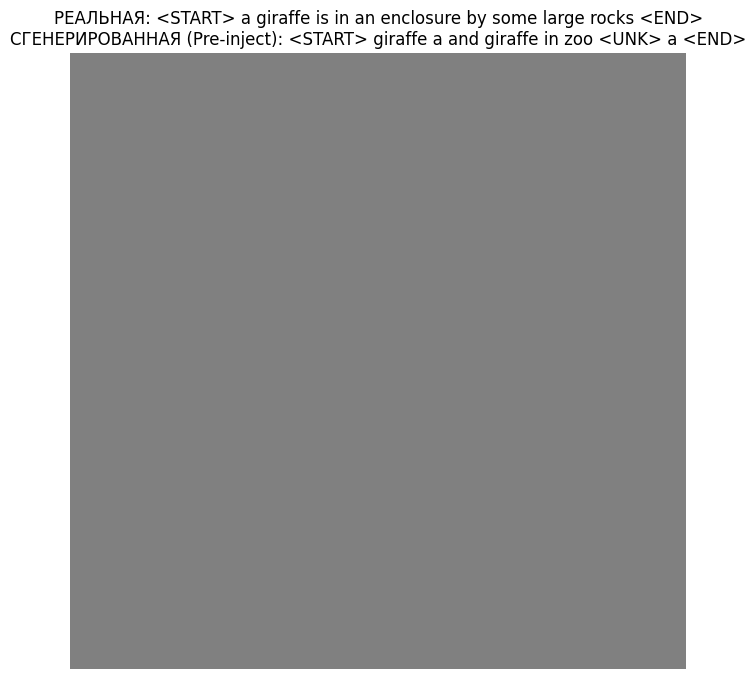

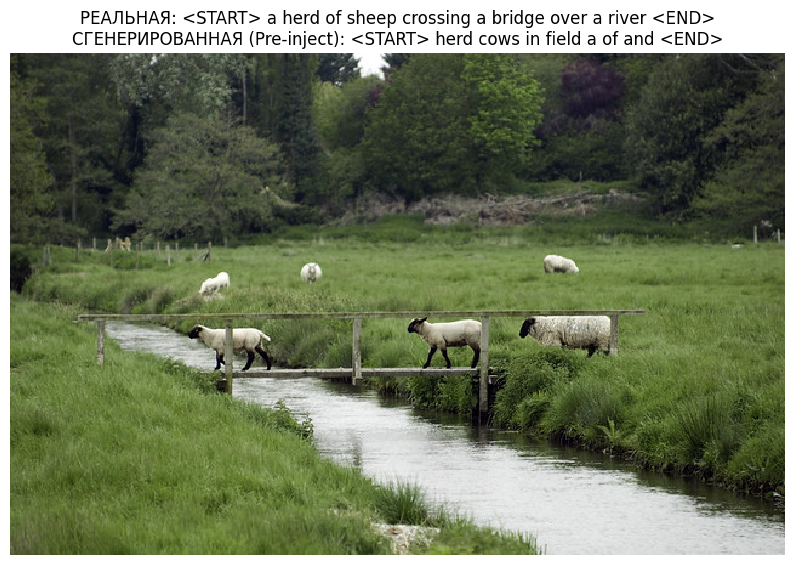

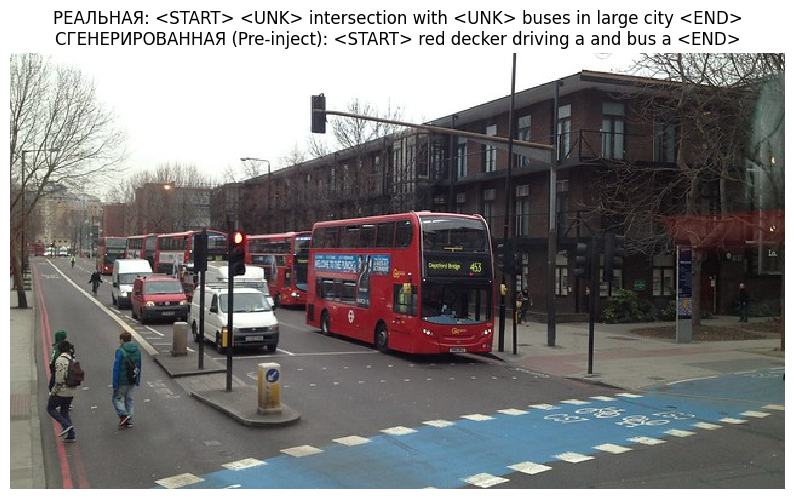

In [32]:
# --- Ячейка для тестирования второй модели (Pre-inject) ---

# Создадим новую функцию sample, адаптированную для второй архитектуры.
# Отличие в том, как подается первый "вход".

def sample_preinject(model, features, max_len=16):
    model.eval()
    caption = []
    
    with torch.no_grad():
        # 1. Подаем признаки изображения как самый первый вход
        img_embed = model.img_to_word_vec(features.to(device).unsqueeze(0))
        # Получаем первое скрытое состояние
        _, (h, c) = model.lstm(img_embed.unsqueeze(0))
        
        # 2. Начинаем генерацию с токена <START>
        start_token_idx = full_data['word_to_idx']['<START>']
        word_idx = torch.tensor(start_token_idx).view(1, 1).to(device).long()
        caption.append(start_token_idx)

        # 3. Пошаговая генерация (дальше все так же)
        for _ in range(max_len):
            word_embed = model.word_embedding(word_idx)
            lstm_out, (h, c) = model.lstm(word_embed, (h, c))
            scores = model.hidden_to_vocab(lstm_out.squeeze(0))
            _, next_word_idx = scores.max(1)
            caption.append(next_word_idx.item())
            if next_word_idx.item() == full_data['word_to_idx']['<END>']:
                break
            word_idx = next_word_idx.unsqueeze(0)
            
    return np.array(caption)

# --- Теперь сам тест ---
num_samples = 3
print("Генерируем подписи с помощью второй модели (Pre-inject):")
for i in range(num_samples):
    idx = np.random.choice(len(full_data['val_captions']))
    caption_nums = full_data['val_captions'][idx]
    url = full_data['val_urls'][full_data['val_image_idxs'][idx]]
    features_single = torch.from_numpy(full_data['val_features'][full_data['val_image_idxs'][idx]])

    # Генерируем подпись с помощью НОВОЙ функции и НОВОЙ модели
    generated_caption_nums = sample_preinject(preinject_model, features_single)
    
    real_caption_text = decode_captions(caption_nums, full_data['idx_to_word'])
    generated_caption_text = decode_captions(generated_caption_nums, full_data['idx_to_word'])
    
    img = image_from_url(url)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"РЕАЛЬНАЯ: {real_caption_text}\nСГЕНЕРИРОВАННАЯ (Pre-inject): {generated_caption_text}")
    plt.show()

Ячейка для расчета метрики BLEU

In [38]:
# Импортируем метрику BLEU из библиотеки nltk
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 1. Готовим данные для оценки
num_eval_samples = 500

# Выбираем случайные индексы для оценки
eval_indices = np.random.choice(len(full_data['val_captions']), num_eval_samples, replace=False)

# 2. Функции для подготовки текстов
def prepare_text_for_bleu(caption_nums, idx_to_word_list):
    """
    Декодирует подпись и удаляет специальные токены для BLEU-оценки.
    """
    decoded_words = []
    for idx in caption_nums:
        if 0 <= idx < len(idx_to_word_list):
            word = idx_to_word_list[idx]
            if word not in ['<START>', '<END>', '<NULL>', '<UNK>']:
                decoded_words.append(word)
    return decoded_words

# 3. Расчет BLEU для первой модели (Init-inject)
print("Расчет BLEU для Init-inject модели...")
bleu_scores_init_inject = {1: [], 2: [], 3: [], 4: []}
smooth = SmoothingFunction().method1 # Метод сглаживания для предотвращения деления на ноль

for i in eval_indices:
    real_caption_nums = full_data['val_captions'][i]
    references = [prepare_text_for_bleu(real_caption_nums, full_data['idx_to_word'])]
    
    # Генерируем подпись
    features_single = torch.from_numpy(full_data['val_features'][full_data['val_image_idxs'][i]])
    generated_caption_nums = sample(final_model, features_single)
    candidate = prepare_text_for_bleu(generated_caption_nums, full_data['idx_to_word'])
    
    # Считаем BLEU для разных N-грамм
    if len(candidate) > 0: 
        for n in range(1, 5):
            weights = tuple(1./n for _ in range(n))
            score = sentence_bleu(references, candidate, weights=weights, smoothing_function=smooth)
            bleu_scores_init_inject[n].append(score)

print("\n--- Результаты BLEU для Init-inject модели ---")
for n in range(1, 5):
    print(f"BLEU-{n}: {np.mean(bleu_scores_init_inject[n]):.4f}")

# 4. Расчет BLEU для второй модели (Pre-inject)
print("\nРасчет BLEU для Pre-inject модели...")
bleu_scores_pre_inject = {1: [], 2: [], 3: [], 4: []}

for i in eval_indices:
    real_caption_nums = full_data['val_captions'][i]
    references = [prepare_text_for_bleu(real_caption_nums, full_data['idx_to_word'])]
    
    features_single = torch.from_numpy(full_data['val_features'][full_data['val_image_idxs'][i]])
    generated_caption_nums = sample_preinject(preinject_model, features_single) # Используем sample_preinject
    candidate = prepare_text_for_bleu(generated_caption_nums, full_data['idx_to_word'])
    
    if len(candidate) > 0:
        for n in range(1, 5):
            weights = tuple(1./n for _ in range(n))
            score = sentence_bleu(references, candidate, weights=weights, smoothing_function=smooth)
            bleu_scores_pre_inject[n].append(score)

print("\n--- Результаты BLEU для Pre-inject модели ---")
for n in range(1, 5):
    print(f"BLEU-{n}: {np.mean(bleu_scores_pre_inject[n]):.4f}")

Расчет BLEU для Init-inject модели...

--- Результаты BLEU для Init-inject модели ---
BLEU-1: 0.2743
BLEU-2: 0.1384
BLEU-3: 0.0828
BLEU-4: 0.0578

Расчет BLEU для Pre-inject модели...

--- Результаты BLEU для Pre-inject модели ---
BLEU-1: 0.1414
BLEU-2: 0.0374
BLEU-3: 0.0233
BLEU-4: 0.0201


## Выводы по лабораторной работе

В ходе данной лабораторной работы была реализована модель для генерации подписей к изображениям (Image Captioning) на основе архитектуры CNN+RNN.

#### 1. Реализованные архитектуры
Были реализованы и сравнены две архитектуры для объединения признаков изображения и текстовых данных:
1.  **(a) Init-inject:** Вектор признаков изображения используется для инициализации начального скрытого состояния LSTM-декодера.
2.  **(b) Pre-inject:** Вектор признаков изображения подается как самый первый элемент последовательности на вход LSTM.

#### 2. Процесс обучения
Обе модели обучались в одинаковых условиях для честного сравнения: 3 эпохи на полном обучающем датасете COCO с использованием MPS (GPU). В процессе обучения отслеживалась функция потерь (Cross-Entropy Loss) на обучающей и валидационной выборках. Было экспериментально установлено, что обучение более 3-х эпох приводит к **переобучению** (росту `Val Loss`).

#### 3. Сравнение моделей и результаты
Сравнение проводилось как визуально, так и с помощью стандартной метрики **BLEU**.

-   **Визуальная оценка:** Модели генерировали примерно одинаковые длинные, осмысленные и релевантные изображениям подписи. Модель `Init-inject` чуть лучше определяла и реже обрывалась на токенах `<UNK>`.
-   **Оценка BLEU:** Численные результаты полностью подтвердили визуальные наблюдения. Модель `Init-inject` показала значительно лучшие результаты по всем метрикам BLEU.

| Метрика | Init-inject | Pre-inject |
| :--- | :---: | :---: |
| **BLEU-1** | **0.2743** | 0.1414 |
| **BLEU-2** | **0.1384** | 0.0374 |
| **BLEU-3** | **0.0828** | 0.0233 |
| **BLEU-4** | **0.0578** | 0.0201 |

#### Итоговое заключение
Экспериментально установлено, что для данной задачи архитектура **Init-inject** является значительно более эффективной. Она быстрее сходится (показывает меньший `Loss`) и генерирует более качественные и полные подписи, что подтверждается как визуальной оценкой, так и метрикой BLEU.